In [1]:
#Import libraries
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import galsim
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import cPickle
import warnings
import glob
import matplotlib
import galFuncs
import re
import time

matplotlib.rcParams['ps.useafm']=True
matplotlib.rcParams['pdf.use14corefonts']=True
#matplotlib.rcParams['text.usetex']=True
matplotlib.rc('font',size=14)

In [2]:
shape_method = "REGAUSS"
wav="800"
shear="shear2"
sl = {"shear1":"0.02-0.0", "shear2":"0.0-0.02"}
sl2 = {"shear1": "0.02", "shear2": "0.02i"}

proc = "metacal"
killShearGT1 = False
if shape_method == "KSB":
    if proc == "control":
        name = "/home/rosenberg/Documents/wl-bias-leaps-top/shear_bias_outputs/control_run_2008/ksb/*"+sl[shear]+"*.pkl"
    elif proc == "metacal":
        name = "/home/rosenberg/Documents/wl-bias-leaps-top/shear_bias_outputs/cosmos_study_1708_ksb/"+shear+"/lambda"+wav+"/*.pkl"
elif shape_method=="REGAUSS":
    name = "/home/rosenberg/Documents/wl-bias-leaps-top/shear_bias_outputs/redrawScaleFactor0.5/%s/*%s*.pkl" % (proc, sl[shear])


In [6]:
fmet = loadfiles(name)
#fcont = loadfiles(name)

9
(2, 5, 2, 1000, 25, 9)


In [7]:
# Make sure everything is the same in metacal and control
for smet, scont in zip(fmet[1:], fcont[1:]):
    assert np.all(smet == scont)
shearList = fmet[1]

rcmet, Rmet = proc1(fmet[0])
rccont, Rcont = proc1(fcont[0])

gnmmet_rc = np.isnan(rcmet)
gnmcont_rc = np.isnan(rccont)
gnm_rc = gnmmet_rc | gnmcont_rc
rcmet[gnm_rc] = np.nan
rccont[gnm_rc] = np.nan

gnmmet_R = np.isnan(Rmet)
gnmcont_R = np.isnan(Rcont)
gnm_R = gnmmet_R | gnmcont_R
Rmet[gnm_R] = np.nan
Rcont[gnm_R] = np.nan

In [10]:
assert np.all(np.isnan(rcmet) == np.isnan(rccont))
assert np.all(np.isnan(Rmet) == np.isnan(Rcont))
print Rcont.shape
print rcmet.shape

(2, 2, 2, 1000, 25, 9)
(2, 5, 2, 1000, 25, 9)


In [11]:
def loadfiles(name):
    fn = sorted(glob.glob(name))
    nrot = len(fn)
    print len(fn)
    res = []
    ident0 = 0
    for i,filename in enumerate(fn):
        fil = open(filename)
        resmetacal = cPickle.load(fil)
        ident = resmetacal[-1]
        assert np.all(ident == np.roll(ident, 1, axis=0))
        assert (i == 0) | np.all(ident == ident0)
        ident0 = ident
        res.append(resmetacal)
        fil.close()
    res = np.stack(res).transpose()
    #res = [np.stack(x, axis=-1) for x in res]
    rece1, rece2, shearList, hlr, sn, q, phiList, ident = res
    hlr, sn, q, phiList, ident = [np.concatenate(x, axis=1) for x in [hlr, sn, q, phiList, ident]]
    rece1, rece2 = [np.concatenate(x, axis=2) for x in [rece1, rece2]]
    assert np.all([shearList[0] == shearList[i] for i in range(len(shearList))])
    shearList = shearList[0]
    # rece: nshear x pairs x ngal*nrot_nopair x nx^2
    # q, phiList, etc: pairs x ngal*nrot_nopair
    #nfiles = nrot_nopair

#     # Size or other cuts
#     smallMask = (hlr>0.1)
#     rece1[:,smallMask,:] = np.nan
#     rece2[:,smallMask,:] = np.nan


    # Define function to convert from e-type to g-type
    ## NOTE: This is a temporary solution
    ## This removes ellipticities greater than one, which do *not* want to do
    ## Instead we will probably use a measurement method that directly returns g-type
    def e2g(e1, e2):
        try:
            sh = galsim.Shear(e1=e1, e2=e2)
            return sh.g1, sh.g2
        except Exception as e:
            #warnings.warn (str(e))
            return np.nan, np.nan

    if shape_method == "REGAUSS":
        e2gVec = np.vectorize(e2g)
        recg1, recg2 = e2gVec(rece1, rece2)
    elif shape_method == "KSB":
        recg1, recg2 = rece1, rece2

    if killShearGT1:
        bad = recg1**2 + recg2**2 > 1
        recg1[bad] = np.nan
        recg2[bad] = np.nan

    # Combine g1, g2 into a single array
    recshape1, recshape2 = recg1, recg2
    recshape = np.stack([recshape1, recshape2])
    #(g1,g2), nshear, 2 (rotpairs), ngal, nx^2


    #Separate last (rotation / pixel size) axis or not
    sh = recshape.shape
    sepLastAx = True
    if not sepLastAx:
        recshape = recshape.reshape(sh+(1,))
    else:
        recshape = recshape.reshape(sh[:3]+(nrot, sh[3]/nrot,sh[4])) #Separate all rotations
        recshape = recshape.transpose(0,1,2,4,5,3)
    print recshape.shape
    #((g1,g2), nshear, 2(rotpairs), ngal, nx^2, nrot)
    return recshape, shearList, hlr, sn, q, phiList, ident

def proc1(recshape):
    # Make shear values easier to access, define indeces
    #print shearList
    shearArr = np.array([[sh.g1, sh.g2] for sh in shearList])
    shearm_i1, shearp_i1 = 1, 2
    shearm_i2, shearp_i2 = 3, 4

    # Calculate R for each galaxy image
    #R = deps_i / dg_j
    den = (shearArr[shearp_i1] - shearArr[shearm_i1] + shearArr[shearp_i2] - shearArr[shearm_i2])
    Ri1 = ((recshape[:, shearp_i1] - recshape[:, shearm_i1]).transpose() / den).transpose() ## dg1: R11 and R21
    Ri2 = ((recshape[:, shearp_i2] - recshape[:, shearm_i2]).transpose() / den).transpose() #dg2: R12 and R22
    R = np.stack([Ri1,Ri2]) #[[R11, R21], [R12, R22]]
    R = R.transpose([1,0] + range(2, len(R.shape))) #[[R11, R12], [R21, R22]]
    #mm = 0.5 * (R[0,0] + R[1,1]) - 1
    #R (2x2), rotpair (2), ngal, nx^2

    # Make Mask: True if any R-component of any rotation of a galaxy is nan
    # shape ngal, nx^2
    galnanmask = np.isnan(R)
    galnanmask = np.any(galnanmask, axis=(0,1,2))

    # True if any shape measurement of any shear of a galaxy is nan (including 0)
    gnm2 = np.isnan(recshape)
    gnm2 = np.any(gnm2, axis=(0,1,2))
    # Combine the two masks
    galnanmask = galnanmask | gnm2

    ls = len(R.shape)
    transpose_arr = range(3,ls) + range(3) # (3,4,0,1,2) or (3,4,5,0,1,2)
    inv_transpose_arr = np.argsort(transpose_arr)
    #Make corresponding entry in other rotation nan if it is nan for one of the rotations
    #Make whole R matrix nan if one entry is nan
    #Match nans for all shears (including 0)
    newr = R.transpose(transpose_arr) # ngal, nx^2, R(2x2), nrot
    newr[galnanmask] = np.nan
    R = newr.transpose(inv_transpose_arr)

    #Match nans for shear / rotation
    #Match nans with R

    newrecshape = recshape.transpose(transpose_arr)
    newrecshape[galnanmask] = np.nan
    recshape = newrecshape.transpose(inv_transpose_arr)
    return recshape, R

def proc2(recshape, R):

    # Average over galaxies, subpixel shifts, rotations, and bootstrap
    def bootstrap(R, recg0, axisListRRand, axisListRMean, axisListRecg0Rand, axisListRecg0Mean, nBootstrap, noBootstrap=False):
        shape = np.array(R.shape)[axisListRRand]
        if noBootstrap:
            return np.array([np.nanmean(R, axis=tuple(axisListRMean))]), np.array([np.nanmean(recg0, axis=tuple(axisListRecg0Mean))])
        else:
            weights = galFuncs.getWeightArr(shape, nBootstrap)
            RBoot = galFuncs.bootstrapArr(R, axisListRRand, axisListRMean, weights)
            tmsBoot = galFuncs.bootstrapArr(recg0, axisListRecg0Rand, axisListRecg0Mean, weights)
            return RBoot, tmsBoot

    axisListRRand, axisListRMean = [3,4], [2,3,4]
    axisListRecg0Rand, axisListRecg0Mean = [2,3], [1,2,3]
    #axisListRRTot, axisListRMTot = [3,4,5], [2,3,4,5]
    #axisListRecg0RTot, axisListRecg0MTot = [2,3,4], [1,2,3,4]
    nBootstrap=1000
    st = time.clock()

    artShear = 0
    RBoot,tmsBoot = bootstrap(R, recshape[:,artShear], axisListRRand, axisListRMean, axisListRecg0Rand, axisListRecg0Mean, nBootstrap, False)
    RBoot, tmsBoot = RBoot.transpose(0,3,1,2), tmsBoot.transpose(0,2,1) # (nBootstrap, nrot, 2x2), (nBootstrap, nrot, g1_g2)
#     print "R: ", RBoot[0,-4]
#     print "Rinv: ", np.linalg.inv(RBoot[0,-4])
#     print "e_rms: ", np.hypot(*tmsBoot[0,-4])
    #print time.clock() - st
    rec_cosmoshear_boot = np.einsum('...jk,...k->...j', np.linalg.inv(RBoot), tmsBoot)
    rec_cosmoshear, rec_cosmoshear_std = np.mean(rec_cosmoshear_boot, axis=0), np.std(rec_cosmoshear_boot, axis=0)
    true_mean_shape, tmsstd = np.mean(tmsBoot, axis=0), np.std(tmsBoot, axis=0)

    cshear_err = rec_cosmoshear_std 
    tms_err = tmsstd 
    return rec_cosmoshear, rec_cosmoshear_std, true_mean_shape, tmsstd

# rec_cosmoshear0, rec_cosmoshear_std0 = rec_cosmoshear.copy(), rec_cosmoshear_std.copy()
# true_mean_shape0, tmsstd0 = true_mean_shape.copy(), tmsstd.copy()
# wav0 = wav
# proc0 = proc
# rec_cosmoshear0bs, rec_cosmoshear_std0bs = rec_cosmoshear0.copy(), rec_cosmoshear_std0.copy()
# true_mean_shape0bs, tmsstd0bs = true_mean_shape0.copy(), tmsstd0.copy()
# ps0 = np.array(pixel_size).copy()
# rec_cosmoshearbs, rec_cosmoshear_stdbs = rec_cosmoshear.copy(), rec_cosmoshear_std.copy()
# true_mean_shapebs, tmsstdbs = true_mean_shape.copy(), tmsstd.copy()

In [13]:
resmet = proc2(rcmet, Rmet)
rescont = proc2(rccont, Rcont)

[[-3.56735766e-07  2.00026282e-02]
 [ 2.20619821e-07  2.00023336e-02]
 [-1.30202802e-07  2.00028500e-02]
 [ 3.52591677e-08  2.00027975e-02]
 [ 1.99688288e-07  2.00043994e-02]
 [ 1.77556746e-07  2.00066005e-02]
 [ 3.05019363e-08  2.00091876e-02]
 [-9.01424885e-08  2.00136950e-02]
 [ 2.15019478e-11  2.00206344e-02]]


In [16]:
rec_cosmoshear, rec_cosmoshear_std, true_mean_shape, tmsstd = rescont
#rec_cosmoshear, rec_cosmoshear_std, true_mean_shape, tmsstd = resmet

In [15]:
rec_cosmoshear0, rec_cosmoshear_std0 = rec_cosmoshear.copy(), rec_cosmoshear_std.copy()
true_mean_shape0, tmsstd0 = true_mean_shape.copy(), tmsstd.copy()

In [17]:
proc = "control"
proc0 = "metacal"
fn = sorted(glob.glob(name))
pixel_size = [float(re.findall("pixelscale0.\d\d?", x)[0][10:]) for x in fn]


In [18]:
print rec_cosmoshear_std0

[[2.10982298e-07 2.88808908e-07]
 [1.82906897e-07 2.74539251e-07]
 [1.61968094e-07 2.65626568e-07]
 [1.41189219e-07 2.65148182e-07]
 [1.35475457e-07 2.65484067e-07]
 [1.46798624e-07 2.65473507e-07]
 [2.68290925e-07 2.67195143e-07]
 [4.47618254e-07 2.75778678e-07]
 [6.64896160e-07 3.06970035e-07]]


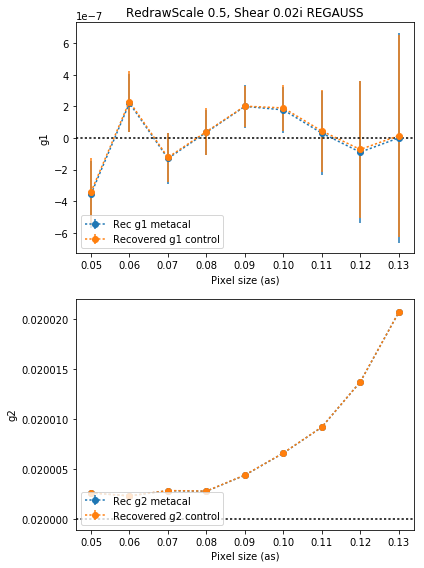

In [21]:
#rotList = np.degrees(phiList[0]).reshape(nrot,phiList[0].shape[0]/nrot)[:,0]
xx = pixel_size
#xx0=ps0
fig,ax = plt.subplots(2,1,figsize=(6,8))
for gindex in range(2):
    gis = str(gindex+1)
    subax=ax[gindex]
    subax.errorbar(xx, rec_cosmoshear0[:,gindex], yerr=rec_cosmoshear_std0[:,gindex], label="Rec g%s %s" % (gis, proc0), fmt='o:')
    subax.errorbar(xx, rec_cosmoshear[:,gindex], yerr=rec_cosmoshear_std[:,gindex], label="Recovered g%s %s" % (gis, proc), fmt='o:')
    #subax.errorbar(xx, true_mean_shape0[:,gindex], yerr=tmsstd0[:,gindex], label="Mean g%s %s" % (gis, proc0), fmt='o:')
    #subax.errorbar(xx, true_mean_shape[:,gindex], yerr=tmsstd[:,gindex], label="Mean g%s %s" % (gis, proc), fmt='o:')

    #plt.errorbar(-5, tot_tms[gindex], yerr=tot_tms_err[gindex], label="Total mean g"+gis, fmt='o')
    #plt.errorbar(-5, rec_cosmoshear_tot[gindex], yerr=tot_cshear_err[gindex], label="Total Rec g"+gis, fmt='o')
    #plt.ylim(0.015, 0.021)
    if gindex==1:
        subax.axhline(0.02, c='k', linestyle=':')
    else:
        subax.axhline(0, c='k', linestyle=':')
    subax.legend(loc='lower left')
    #plt.title("Total mean g%s %.3g, Total Rec g%s %.3g" % (gis, tot_tms[gindex], gis, tot_cosmoshear[gindex]))
    #plt.xlabel("Pair Orientation (degrees)")
    subax.set_xlabel("Pixel size (as)")
    subax.set_ylabel("g"+gis)
ax[0].set_title("RedrawScale 0.5, Shear %s %s" % (sl2[shear], shape_method))

plt.tight_layout()
#ax[0].set_ylim(-0.1,0.025)
#ax[1].set_ylim(-0.05,0.05)
#plt.savefig("/home/rosenberg/Documents/wl-bias-leaps-top/shear_bias_outputs/recovered_g_vs_pixelsize_mcal-control_shear_0.02i_regauss_match_redraw0.5.png")

In [226]:
met0 = rcmet[1,0,0,:,:,-1]
cont0 = rccont[1,0,0,:,:,-1]

rcmet.shape
rccont.shape

(2, 5, 2, 1000, 25, 9)

-1.8568972484896067e-05


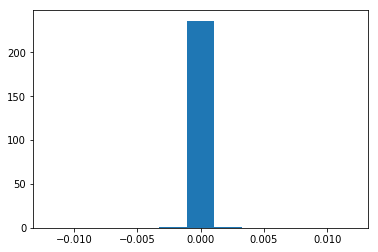

In [227]:
diff = (met0 - cont0).flatten()
diff = diff[~np.isnan(diff)]
plt.hist(diff, bins=np.linspace(-0.012,0.012,12))
print np.mean(diff)

In [38]:
print xx[0], rec_cosmoshear

0.05 [[-5.28469078e-08  2.00044007e-02]
 [-3.55569166e-08  2.00050191e-02]
 [-6.97886645e-08  2.00077241e-02]
 [-1.03986591e-05  2.00146115e-02]
 [ 6.01277707e-06  2.00557315e-02]
 [ 1.51112936e-05  2.01431601e-02]
 [-1.73168838e-06  2.01750049e-02]
 [ 1.90239015e-05  2.04766531e-02]
 [-4.41010163e-05  2.06314554e-02]]


In [64]:
print rec_cosmoshear - rec_cosmoshear_nosizecut

[[1.07870256e-04 9.69540941e-05]
 [1.06719405e-04 9.68328857e-05]
 [6.77984400e-05 1.16269615e-04]
 [6.45043481e-05 1.18786346e-04]
 [5.97297904e-05 1.22338149e-04]
 [5.34084852e-05 1.26306569e-04]
 [4.58414023e-05 1.30010122e-04]
 [3.66793819e-05 1.34194345e-04]
 [2.73435578e-05 1.40122131e-04]]


In [51]:
#rec_cosmoshear_nosizecut = rec_cosmoshear.copy()

In [34]:
#with size cut
print rec_cosmoshear

[[1.99503273e-02 9.23328610e-05]
 [1.99483844e-02 9.31438868e-05]
 [1.99683909e-02 8.30712873e-05]
 [1.99614871e-02 8.51167492e-05]
 [1.98937645e-02 8.86832074e-05]
 [1.97127828e-02 9.31200440e-05]
 [1.94269077e-02 9.71581977e-05]
 [1.90865511e-02 1.03593215e-04]
 [1.87694976e-02 1.13521199e-04]]


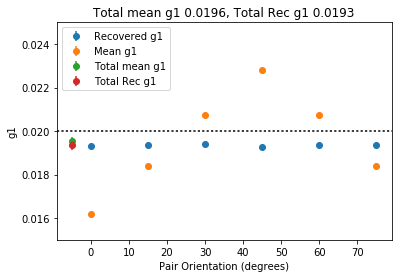

In [151]:
rotList = np.degrees(phiList[0]).reshape(nrot,phiList[0].shape[0]/nrot)[:,0]
gindex = 0
gis = str(gindex+1)
plt.errorbar(rotList, rec_cosmoshear[:,gindex], yerr=cshear_err[:,gindex], label="Recovered g"+gis, fmt='o')
plt.errorbar(rotList, true_mean_shape[:,gindex], yerr=tms_err[:,gindex], label="Mean g"+gis, fmt='o')
plt.errorbar(-5, tot_tms[gindex], yerr=tot_tms_err[gindex], label="Total mean g"+gis, fmt='o')
plt.errorbar(-5, rec_cosmoshear_tot[gindex], yerr=tot_cshear_err[gindex], label="Total Rec g"+gis, fmt='o')
plt.ylim(0.015, 0.025)
plt.axhline(0.02, c='k', linestyle=':')
plt.legend()
plt.title("Total mean g%s %.3g, Total Rec g%s %.3g" % (gis, tot_tms[gindex], gis, tot_cosmoshear[gindex]))
plt.xlabel("Pair Orientation (degrees)")
plt.ylabel("g"+gis)
#plt.savefig("/home/rosenberg/Documents/wl-bias-leaps-top/shear_bias_outputs/recovered_g_vs_rot_0.02i.png")

## Plotting

In [130]:
R.shape

(2, 2, 2, 200, 25, 6)

In [131]:
hlr_orig = hlr[0,:hlr.shape[1]/nrot]
q_orig = q[0,:q.shape[1]/nrot]

In [132]:
Rrot0 = R[:,:,0,:,:,0]
rotFront = R[:,:,0,:,:]
rotFront = rotFront.transpose([-1]+range(0,len(rotFront.shape)-1))
rotFront = np.nanmean(rotFront, axis=-1)
print rotFront.shape
Rrot0_margsubpix = np.nanmean(Rrot0,axis=-1)

(6, 2, 2, 200)


/software/rhel7/lib64/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: Mean of empty slice


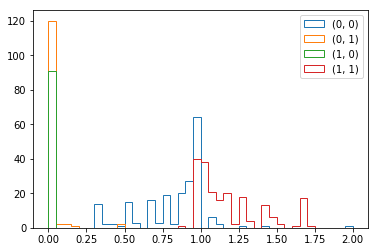

In [133]:
for i in range(2):
    for j in range(2):
        plt.hist(Rrot0_margsubpix[i,j],bins =np.linspace(0,2,41),histtype='step', label=str((i,j)))
plt.legend(loc='upper right')

Rotation 0


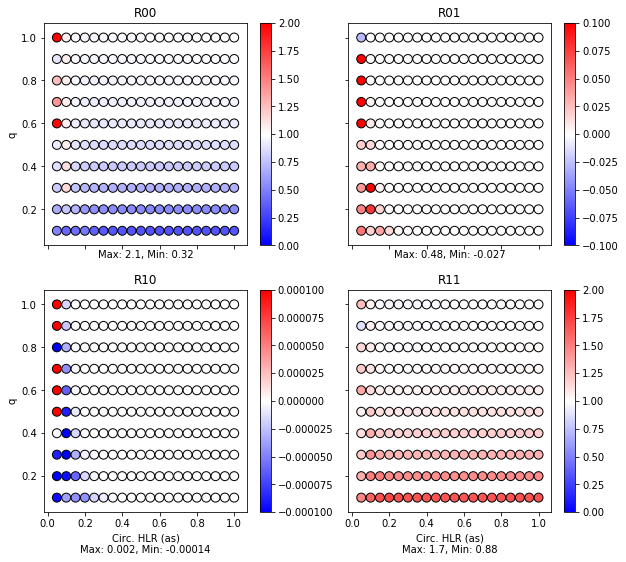

Rotation 15


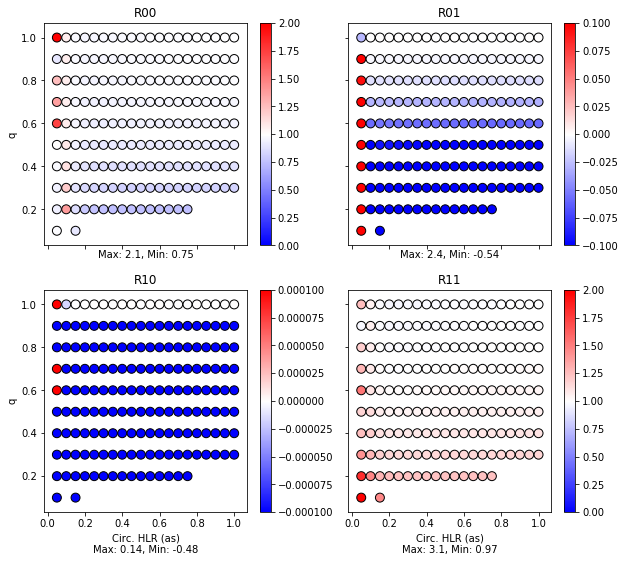

Rotation 30


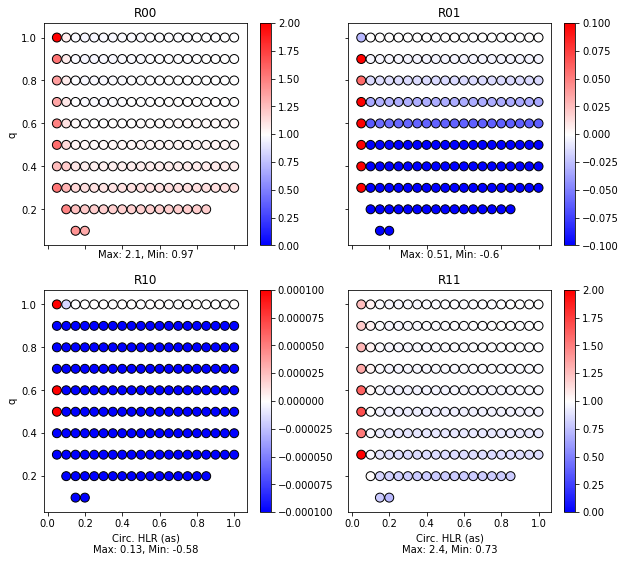

Rotation 45


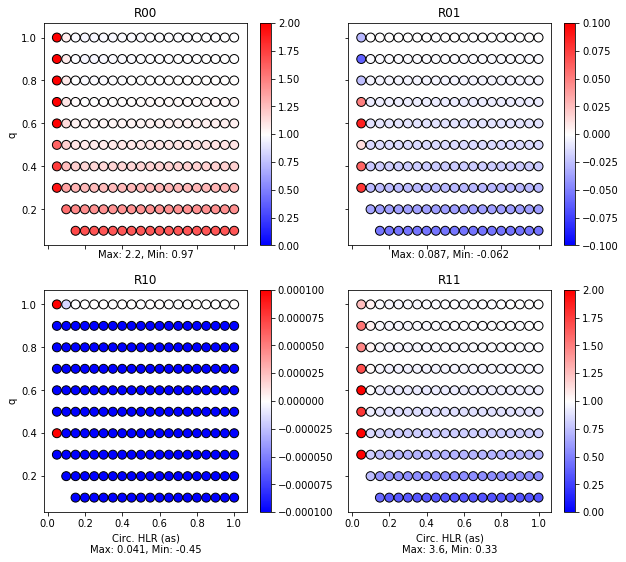

Rotation 60


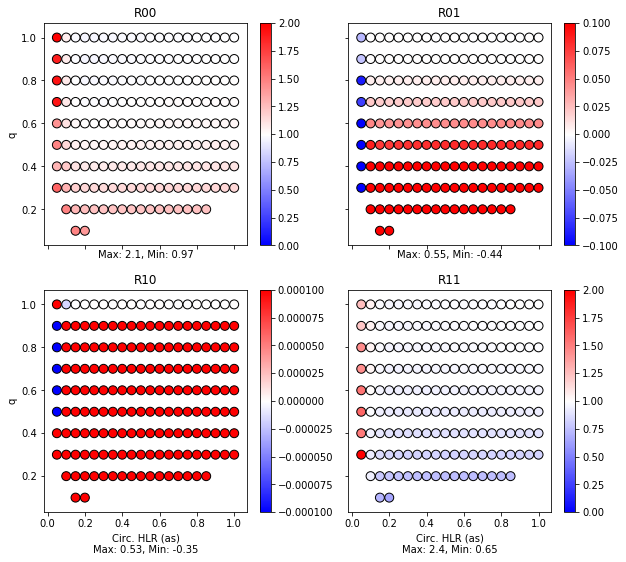

Rotation 75


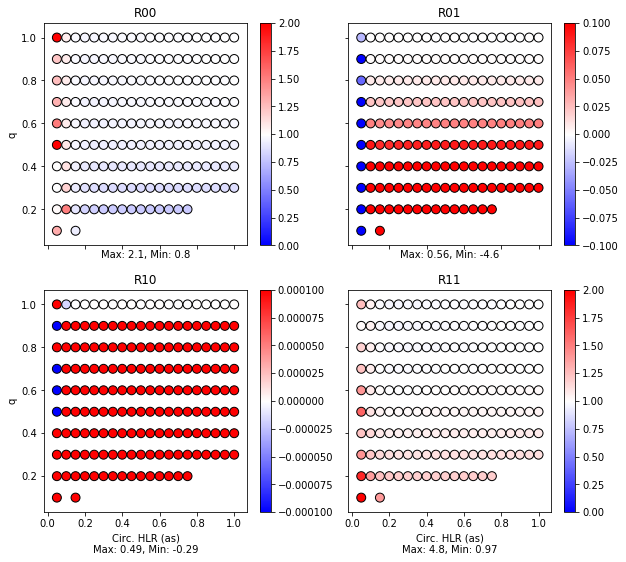

In [134]:
subR = Rrot0_margsubpix #The slice of rotations/subpixel shifts to plot R for
vm=2.0
vm2=1e-1
vm3=1e-4
for ii, subR in enumerate(rotFront):
    print 'Rotation %d'% np.round(rotList[ii])
    fig, ax = plt.subplots(2,2,figsize=(10,9), sharex=True, sharey=True)
    for i in range(2):
        for j in range(2):
            subax = ax[i,j]
            if i == j:
                sct = subax.scatter(hlr_orig, q_orig, c=subR[i,j], vmin=0, vmax=vm, cmap=cm.bwr, edgecolor='k', s=80)
            elif i==0:
                sct = subax.scatter(hlr_orig, q_orig, c=subR[i,j], cmap=cm.bwr, vmin=-vm2, vmax=vm2, edgecolor='k', s=80)
            elif i==1:
                sct = subax.scatter(hlr_orig, q_orig, c=subR[i,j], vmin=-vm3, vmax=vm3, cmap=cm.bwr, edgecolor='k', s=80)
            rmax, rmin = np.nanmax(subR[i,j]), np.nanmin(subR[i,j])
            maxmintext = "Max: %.2g, Min: %.2g" % (rmax, rmin)
            cb = fig.colorbar(sct, ax=ax[i,j])
            if i == 0:
                subax.set_xlabel(maxmintext)
            else:
                subax.set_xlabel('Circ. HLR (as)\n' + maxmintext)
            subax.set_title('R%d%d' % (i, j))
    ax[0,0].set_ylabel('q')
    ax[1,0].set_ylabel('q')
    #plt.tight_layout()
    plt.show()
    #plt.savefig('/home/rosenberg/Documents/wl-bias-leaps-top/shear_bias_outputs/responsivity_rot0deg.png')

In [47]:


recgL = []
for i in range(nBootstrap):
    invR = np.linalg.inv(RBoot[i])
    recg = np.matmul(invR, tmsBoot[i])
    recgL.append(recg)
recg = np.array(recgL)
print np.mean(recg,axis=0), np.std(recg,axis=0)

[0.01928277 0.00011829] [0.00111411 0.00116372]


In [48]:
# # Load files
# filename='/home/rosenberg/Documents/wl-bias-leaps-top/shear_bias_outputs/measErrs_diskonly_grid_n1.0_rot0deg_lambda800_shear5_cosmoshear0.02-0.0_200gals_metacalshear_lanczos100_nx5.pkl'
# fn2='/home/rosenberg/Documents/wl-bias-leaps-top/shear_bias_outputs/measErrs_diskonly_grid_n1.0_rot90deg_lambda800_shear5_cosmoshear0.02-0.0_200gals_metacalshear_lanczos100_nx5.pkl'
# fil1 = open(filename)
# resmetacal=cPickle.load(fil1)
# fil1.close()
# fil2 = open(fn2)
# rm2 = cPickle.load(fil2)
# fil2.close()

# rece1, rece2, shearList, hlr, sn, q, phiList, ident = resmetacal
# rece12, rece22, shearList2, hlr2, sn2, q2, phiList2, ident2 = rm2

# # Combine different rotations into one array
# rece1, rece2 = np.stack((rece1, rece12),axis=-1), np.stack((rece2, rece22), axis=-1)
# #rece has shape nshear x ngal x nx^2 x nrot
# print rece1.shape